In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import geopandas as gpd
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import shapely
import itertools
import networkx as nx

In [3]:
# Load trips
traslados_complete = pd.read_csv('Day0_Full_Filtered.csv')
traslados_origen = gpd.read_file('Day0_FiltCent_origin.geojson')
traslados_destino = gpd.read_file('Day0_FiltCent_destination.geojson')

# Get distance in km per trip as separate dataset
distances = []
for i in range(len(traslados_origen)):
    lat_origen = traslados_origen.geometry[i].y
    lon_origen = traslados_origen.geometry[i].x
    lat_destino = traslados_destino.geometry[i].y
    lon_destino = traslados_destino.geometry[i].x
    
    d = ((lat_destino - lat_origen) * 111139)**2 + ((lon_destino - lon_origen) * 111139)**2
    distances.append(np.sqrt(d))

In [4]:
traslados = traslados_complete.copy()

traslados['distance'] = distances
traslados = traslados[traslados['distance'] > 500]

In [5]:
# Split trips into two datasets: 60% for one and 40% for the other
traslados_particular = traslados.sample(frac=0.6, random_state=37)
traslados_publico = traslados.drop(traslados_particular.index)

In [6]:
roadintersections = pd.read_csv('intersections_bysector.csv')
publicintersections = pd.read_csv('intersections_publico_bysector.csv')

In [7]:
# Load gexf files
camion = nx.read_gexf('red_transporte-publico.gexf')
carro = nx.read_gexf('red-vialidades.gexf')

In [8]:
def find_route(G, start_node, end_node):
    try:
        # Find shortest path based on nodes
        path = nx.shortest_path(G, source=start_node, target=end_node, weight='length')
        
        # Track the road names used along the path
        route = []
        road_route = []
        current_road = G.edges[path[0], path[1]]['road']
        segment = [path[0]]  # Initialize with the start node
        
        for i in range(1, len(path)):
            edge_road = G.edges[path[i-1], path[i]]['road']
            if edge_road != current_road:
                # Add the completed segment to the route
                segment.append(path[i-1])
                route.append((current_road, segment))
                road_route.append(current_road)
                
                # Start a new segment on a different road
                current_road = edge_road
                segment = [path[i-1]]
                
            segment.append(path[i])
        
        # Add the final segment to the route
        route.append((current_road, segment))
        road_route.append(current_road)
        
        return road_route, route
    
    except nx.NetworkXNoPath:
        return f"No route found from {start_node} to {end_node}."

In [9]:
trips_1 = traslados_particular.copy()
trips_1 = trips_1.reset_index(drop=True)
trips_1 = trips_1[['h3_origin', 'h3_destination', 'hour_origin', 'dsemana_origin', 'count', 'distance']]
trips_1['fullpath'] = None
trips_1['roadpath'] = None

for i in range(len(trips_1)):
    origen = trips_1['h3_origin'][i]
    destino = trips_1['h3_destination'][i]

    if origen not in carro.nodes or destino not in carro.nodes:
        trips_1['fullpath'][i] = None
        trips_1['roadpath'][i] = None
        continue
    
    # Find the route between origin and destination
    roads, route = find_route(carro, origen, destino)
    trips_1['fullpath'][i] = route
    trips_1['roadpath'][i] = roads

In [10]:
trips_2 = traslados_publico.copy()
trips_2 = trips_2.reset_index(drop=True)
trips_2 = trips_2[['h3_origin', 'h3_destination', 'hour_origin', 'dsemana_origin', 'count', 'distance']]
trips_2['fullpath'] = None
trips_2['roadpath'] = None

for i in range(len(trips_2)):
    origen = trips_2['h3_origin'][i]
    destino = trips_2['h3_destination'][i]
    
    if origen not in camion.nodes or destino not in camion.nodes:
        trips_2['fullpath'][i] = None
        trips_2['roadpath'][i] = None
        continue

    # Find the route between origin and destination
    roads, route = find_route(camion, origen, destino)
    trips_2['fullpath'][i] = route
    trips_2['roadpath'][i] = roads

In [12]:
path_trips_1 = trips_1.copy()

# Remove null paths and paths with less than 3 segments
path_trips_1 = path_trips_1[path_trips_1['roadpath'].notnull()]
path_trips_1 = path_trips_1[path_trips_1['roadpath'].apply(lambda x: len(x) > 3)]

path_trips_1['roadpath'] = path_trips_1['roadpath'].apply(lambda x: str(x))

roadpathcount = path_trips_1.groupby(str('roadpath')).agg({'count': 'sum'}).reset_index().sort_values('count', ascending=False)
print(roadpathcount)

                                              roadpath  count
233  ['Mariano Matamoros', 'Av. Benito Juárez', 'Av...     35
59   ['Av. Simón Bolivar', 'Av. Francisco I. Madero...     24
57   ['Av. Simón Bolivar', 'Av. Francisco I. Madero...     22
199  ['Licenciado José Benítez', 'Av. Dr. José Eleu...     22
216  ['Manuel Gómez Pedraza', 'Jordán', 'Av. Adolfo...     21
..                                                 ...    ...
185  ['Libertad', 'Av. Félix Uresti Gómez', 'Antoni...      1
77   ['Belisario Domínguez', 'Av. Constitución', 'A...      1
187  ['Libertad', 'Av. Félix Uresti Gómez', 'Av. Co...      1
76   ['Belisario Domínguez', 'Av. Constitución', 'A...      1
0    ['Antonio Coello', 'Av. Francisco I. Madero', ...      1

[293 rows x 2 columns]


In [13]:
from shapely.geometry import LineString
from shapely.ops import split

In [14]:
red_vial = gpd.read_file('data_transporte_inside.geojson')

In [15]:
def get_road_geometry(route):
    selected_geometries = red_vial[red_vial['nombre'].isin(route)].copy()

    # Identify Intersections
    intersection_points = []
    for i, geom1 in enumerate(selected_geometries.geometry):
        for j, geom2 in enumerate(selected_geometries.geometry):
            if i < j:  # Avoid redundant checks
                if geom1.intersects(geom2):
                    intersection_points.append(geom1.intersection(geom2))

    # Split Each Geometry at Intersection Points
    split_segments = []
    for _, row in selected_geometries.iterrows():
        geometry = row.geometry
        for point in intersection_points:
            if geometry.intersects(point):
                # Split geometry at intersection point and add segments to list
                segments = split(geometry, point).geoms
                split_segments.extend(segments)
            else:
                # Add whole geometry if no intersection
                split_segments.append(geometry)

    # Only keep the segments that are within the selected IDs and have valid lengths
    split_segments = [seg for seg in split_segments if seg.length > 0]

    # Create a new LineString combining the segments between intersections
    final_geometry = LineString()
    for seg in split_segments:
        final_geometry = final_geometry.union(seg)

    # If final geometry is an empty LineString, return geometry of the first road as LineString
    if final_geometry.is_empty:
        final_geometry = selected_geometries.geometry.values[0]
    
    return final_geometry

In [16]:
new_publicnetwork = pd.DataFrame(columns=['id', 'name', 'geometry'])

# Convert the roadpathcount to a list
roadpath_uniquelists = roadpathcount['roadpath'].apply(lambda x: eval(x)).tolist()

count = 0

for road in roadpath_uniquelists:
    count += 1
    road_geom = get_road_geometry(road)
    road_id = 9990000 + count
    identifier = f"newroute{count}"
    route = [road_id, identifier, road_geom]

    # Add route to the current dataframe
    new_publicnetwork = pd.concat([pd.DataFrame([route], columns=new_publicnetwork.columns), new_publicnetwork], ignore_index=True)

In [17]:
# Convert to GeoDataFrame, export to GeoJSON
newnetwork_gdf = gpd.GeoDataFrame(new_publicnetwork, geometry='geometry')
newnetwork_gdf.to_file('new_publicnetwork.geojson', driver='GeoJSON')

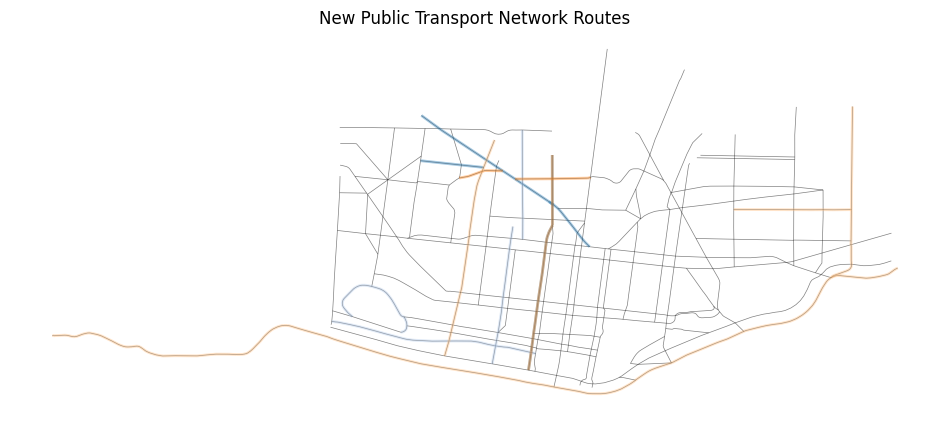

In [18]:
# Plot 10 random routes from the new public network, each in a different color
fig, ax = plt.subplots(figsize=(12, 12))
red_vial.plot(ax=ax, color='black', linewidth=0.5, alpha=0.5)
newnetwork_gdf.sample(4).plot(ax=ax, color=[plt.cm.tab20(i) for i in range(4)], linewidth=2, alpha=0.4)
plt.title('New Public Transport Network Routes')
plt.axis('off')
plt.show()

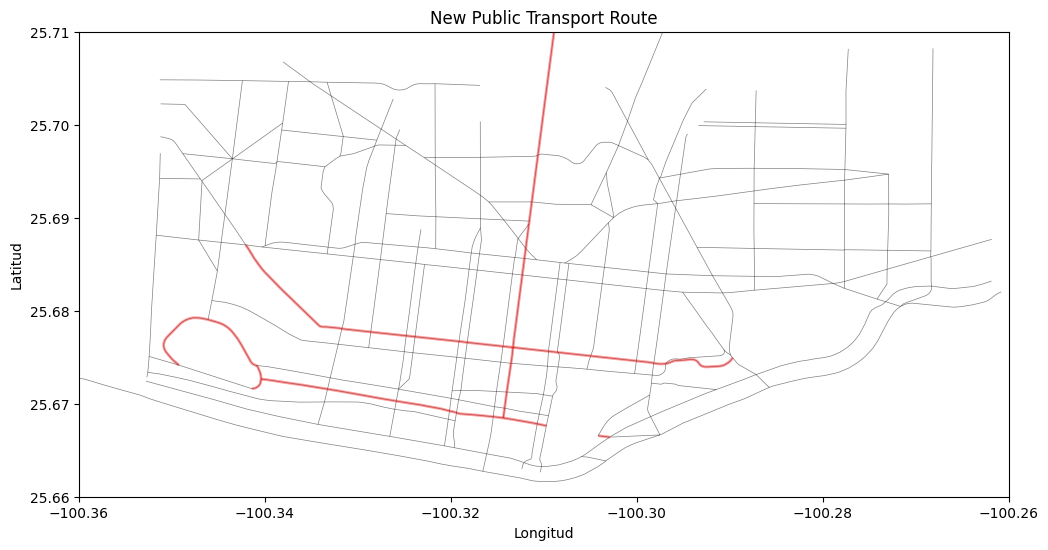

In [19]:
# Plot 'newroute89'
fig, ax = plt.subplots(figsize=(12, 12))
red_vial.plot(ax=ax, color='black', linewidth=0.5, alpha=0.5)
newnetwork_gdf[newnetwork_gdf['id'] == 9990098].plot(ax=ax, color='red', linewidth=2, alpha=0.4)
#newnetwork_gdf[newnetwork_gdf['id'] == 9990089].plot(ax=ax, color='red', linewidth=2, alpha=0.4)
plt.title('New Public Transport Route')
ax.set_xlabel("Longitud")
ax.set_xlim(-100.36, -100.26)
ax.set_ylabel("Latitud")
ax.set_ylim(25.66, 25.71)
plt.show()

In [23]:
roadpath_uniquelists[97]

['Profesor José Silvestre Aramberri',
 'Vicente Guerrero',
 'Fray Servando Padre Mier',
 'Licenciado José Benítez']

In [20]:
# Load region of interest
workingarea = gpd.read_file('workingarea.geojson')

In [21]:
# For each element in worknnig area, check which elements of the transport data are inside
transport_by_area = workingarea.copy()

for i in range(0,len(transport_by_area)):
    transport_by_area.loc[i,'transporte_inside'] = newnetwork_gdf.within(transport_by_area.loc[i,'geometry']).sum()

sectors_workingarea_list = workingarea['h3_polyfill'].tolist()
intersections_bysector_df = pd.DataFrame(columns=['vialidad']+sectors_workingarea_list)

In [22]:
for road,iter in newnetwork_gdf.iterrows():
    # Get road geometry
    road_geom = iter.geometry
    # Get road name
    road_name = iter['name']
    
    # Get intersections between road and working area sectors
    intersections = workingarea[workingarea.intersects(road_geom)]
    # Get list of sectors that intersect with the road
    intersections_list = intersections['h3_polyfill'].tolist()
    # Create a binary list of sectors that intersect with the road
    intersections_bin = [1 if sector in intersections_list else 0 for sector in sectors_workingarea_list]

    # Store obtained data in a row
    row = [road_name]+intersections_bin
    # Append row to the dataframe
    intersections_bysector_df.loc[len(intersections_bysector_df)] = row

KeyboardInterrupt: 

In [ ]:
# Join rows with same road name
intersections_bysector_df = intersections_bysector_df.groupby('vialidad').sum().reset_index()

# Convert any values greater than 1 to 1
intersections_bysector_df[sectors_workingarea_list] = intersections_bysector_df[sectors_workingarea_list].applymap(lambda x: 1 if x > 1 else x)

# Export to CSV
intersections_bysector_df.to_csv('intersections_bysector_public2.csv', index=False)

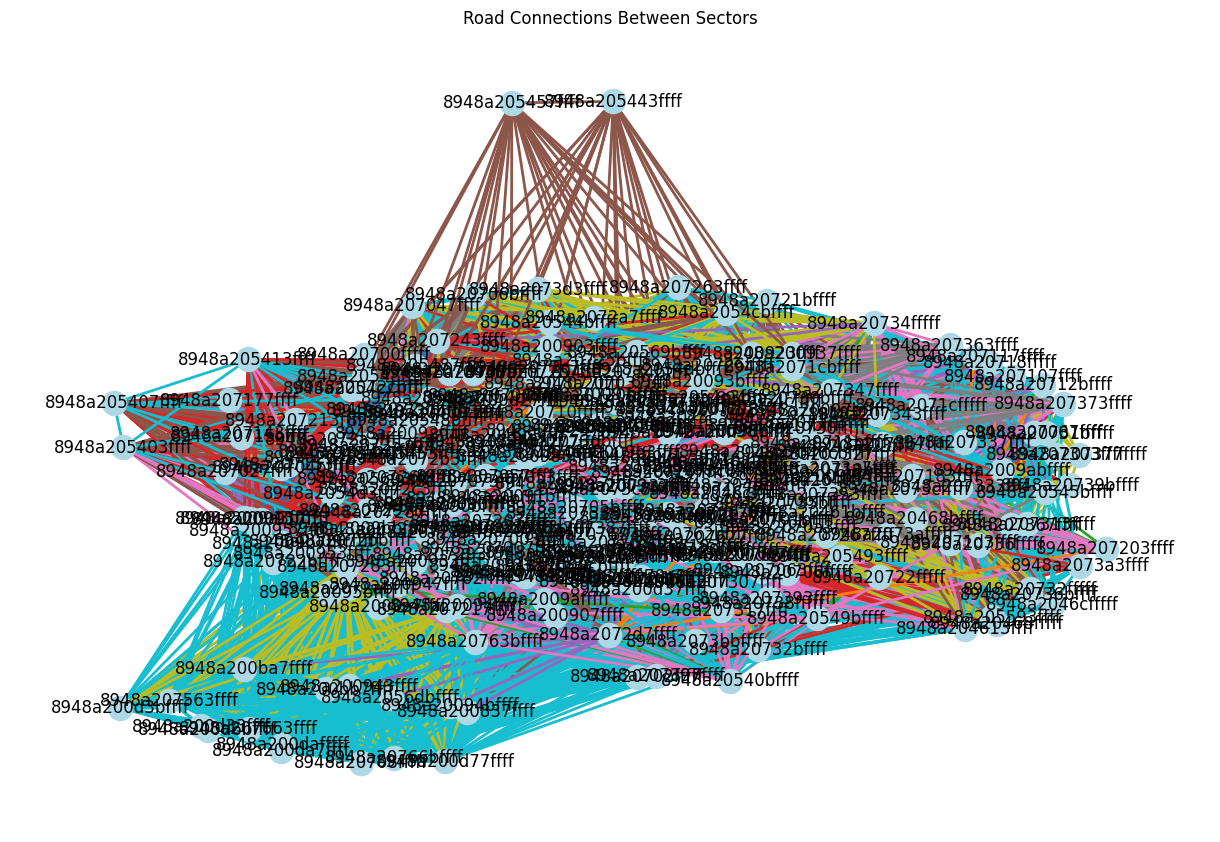

In [ ]:
# Initialize the graph
nuevocamion = nx.Graph()

# Create a color map
unique_colors = plt.cm.get_cmap('tab10', len(intersections_bysector_df))

# Iterate over each row in intersections_bysector_df to add edges
for idx, row in intersections_bysector_df.iterrows():
    road_name = row['vialidad']
    
    # Get sectors connected by this road (where intersection is 1)
    sectors_connected = [sector for sector, intersect in zip(sectors_workingarea_list, row[1:]) if intersect == 1]
    
    # Add edges between each pair of connected sectors for this road
    color = unique_colors(idx)  # Unique color for this road
    for sector1, sector2 in itertools.combinations(sectors_connected, 2):
        # Add edge with a color attribute for visualization
        nuevocamion.add_edge(sector1, sector2, color=color, label=road_name)

# Plot the graph
pos = nx.spring_layout(nuevocamion)  # Layout for better visualization
edges = nuevocamion.edges(data=True)
edge_colors = [edge[2]['color'] for edge in edges]  # Extract edge colors

plt.figure(figsize=(12, 8))
nx.draw(nuevocamion, pos, with_labels=True, node_color="lightblue", edge_color=edge_colors, width=2, edge_cmap=unique_colors)
plt.title("Road Connections Between Sectors")
plt.show()

In [ ]:
def find_route2(G, start_node, end_node):
    try:
        # Find shortest path based on nodes
        path = nx.shortest_path(G, source=start_node, target=end_node, weight='length')
        
        # Track the road names used along the path
        route = []
        road_route = []
        current_road = G.edges[path[0], path[1]]['label']
        segment = [path[0]]  # Initialize with the start node
        
        for i in range(1, len(path)):
            edge_road = G.edges[path[i-1], path[i]]['label']
            if edge_road != current_road:
                # Add the completed segment to the route
                segment.append(path[i-1])
                route.append((current_road, segment))
                road_route.append(current_road)
                
                # Start a new segment on a different road
                current_road = edge_road
                segment = [path[i-1]]
                
            segment.append(path[i])
        
        # Add the final segment to the route
        route.append((current_road, segment))
        road_route.append(current_road)
        
        return road_route, route
    
    except nx.NetworkXNoPath:
        return f"No route found from {start_node} to {end_node}."

In [ ]:
trips_nn = traslados_publico.copy()
trips_nn = trips_nn.reset_index(drop=True)
trips_nn = trips_nn[['h3_origin', 'h3_destination', 'hour_origin', 'dsemana_origin', 'count', 'distance']]
trips_nn['fullpath'] = None
trips_nn['roadpath'] = None

for i in range(len(trips_nn)):
    origen = trips_nn['h3_origin'][i]
    destino = trips_nn['h3_destination'][i]
    
    if origen not in nuevocamion.nodes or destino not in nuevocamion.nodes:
        trips_nn['fullpath'][i] = None
        trips_nn['roadpath'][i] = None
        continue
    else:
        # Find the route between origin and destination
        roads, route = find_route2(nuevocamion, origen, destino)
        trips_nn['fullpath'][i] = route
        trips_nn['roadpath'][i] = roads

In [ ]:
path_trips = trips_nn.copy()

# Remove null paths
path_trips = path_trips[path_trips['roadpath'].notnull()]

# Convert roadpath to string
path_trips['roadpath'] = path_trips['roadpath'].apply(lambda x: str(x))

# Group by roadpath and sum the counts
trips_per_route = path_trips.groupby(str('roadpath')).agg({'count': 'sum'}).sort_values('count', ascending=False).reset_index()
print(trips_per_route)

                           roadpath  count
0                    ['newroute98']   2572
1                    ['newroute94']   1174
2                    ['newroute93']   1139
3                    ['newroute89']   1087
4                    ['newroute96']    822
..                              ...    ...
623  ['newroute199', 'newroute191']      1
624   ['newroute278', 'newroute86']      1
625   ['newroute81', 'newroute123']      1
626   ['newroute195', 'newroute66']      1
627  ['newroute283', 'newroute249']      1

[628 rows x 2 columns]


In [ ]:
# Export to CSV
trips_per_route.to_csv('trips_per_route_public2.csv', index=False)

In [ ]:
# Initialize the graph
G = nx.Graph()

# Create a color map
unique_colors = plt.cm.get_cmap('tab10', len(intersections_bysector_df))

# Iterate over each row in intersections_bysector_df to add edges
for idx, row in intersections_bysector_df.iterrows():
    road_name = row['vialidad']
    
    # Get sectors connected by this road (where intersection is 1)
    sectors_connected = [sector for sector, intersect in zip(sectors_workingarea_list, row[1:]) if intersect == 1]
    
    # Add edges between each pair of connected sectors for this road
    color = unique_colors(idx)  # Unique color for this road
    for sector1, sector2 in itertools.combinations(sectors_connected, 2):
        # Add edge with a color attribute for visualization
        G.add_edge(sector1, sector2, label=road_name)

# Export to GEXF
nx.write_gexf(G, 'new_publicnetwork.gexf')